# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [152]:
import numpy as np 
import matplotlib.pyplot as plt 
import math  
import time 
from numpy import linalg   
import random  

In [153]:
random.seed(42) 

In [154]:
def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

In [155]:
def RandK(percent, vector, d):   
    k = int(percent * d)
    indices = np.random.choice(d, k, replace=True) 
    new_vector = np.zeros(d) 
    new_vector[indices] = vector[indices]
    return (1/percent) * new_vector

In [156]:
def TopK(percent, vector, d):  
    k = int(percent * d)
    indices = np.argpartition(np.absolute(vector), -k)[-k:]
    new_vector = np.zeros(d) 
    new_vector[indices] = vector[indices]
    return new_vector

In [157]:
def Compression(name, percent, vector, d): 
    if(name=='RandK'): 
        return RandK(percent, vector, d) 
    elif(name=='TopK'): 
        return TopK(percent, vector, d)

In [158]:
def grad(A, b, x, d):  
    gr = np.zeros(d) 
    gr = np.dot(A, x) - b 
    return gr 

In [319]:
class GradientDescent: 
    def __init__(self, A, b, max_info, lr, workers, name, percents, d): 
        self.matrix = A 
        self.bias = b 
        self.max_info = max_info  
        self.lr = lr 
        self.x = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d)
        for i in range(0, self.max_info, self.k * self.workers):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)

            for j in range(self.workers): 
                h = grad(self.matrix[j], self.bias[j], self.x, self.d)  
                full_g += h   
                g += Compression(self.name, self.percents, h, self.d)  
            
            g = (1/self.workers) * g 
            full_g = (1/self.workers) * full_g  
            self.x = self.x - self.lr * g 
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.information_send.append(i + self.workers * self.k) 

In [159]:
L = 1000 
mu = 1 
d = 100 
n = 10  

A = [] 
b = []
for i in range(n): 
    A.append(generate_matrix(d, mu, L))  
    b.append(np.random.normal(d)) 

In [291]:
gd_rand_1 = GradientDescent(A, b,  10**6, 1/(4*L * (1 + 2 * 100 * 1/n)), n, 'RandK', 0.01, d)   
gd_rand_5 = GradientDescent(A, b,  10**6, 1/(4*L * (1 + 2 * 20 * 1/n)), n, 'RandK', 0.05, d) 
gd_rand_10 = GradientDescent(A, b, 10**6, 1/(4*L * (1 + 2 * 10 * 1/n)), n, 'RandK', 0.1, d) 
gd_rand_20 = GradientDescent(A, b, 10**6, 1/(4*L * (1 + 2 * 5 * 1/n)), n, 'RandK', 0.2, d)

In [292]:
gd_rand_1.fit() 
gd_rand_5.fit() 
gd_rand_10.fit() 
gd_rand_20.fit() 

In [320]:
gd_top_10 = GradientDescent(A, b, 10**6, 4/(4 * L * (1 + 2 * 10 * 1/n)), n, 'TopK', 0.1, d)
gd_top_10.fit() 

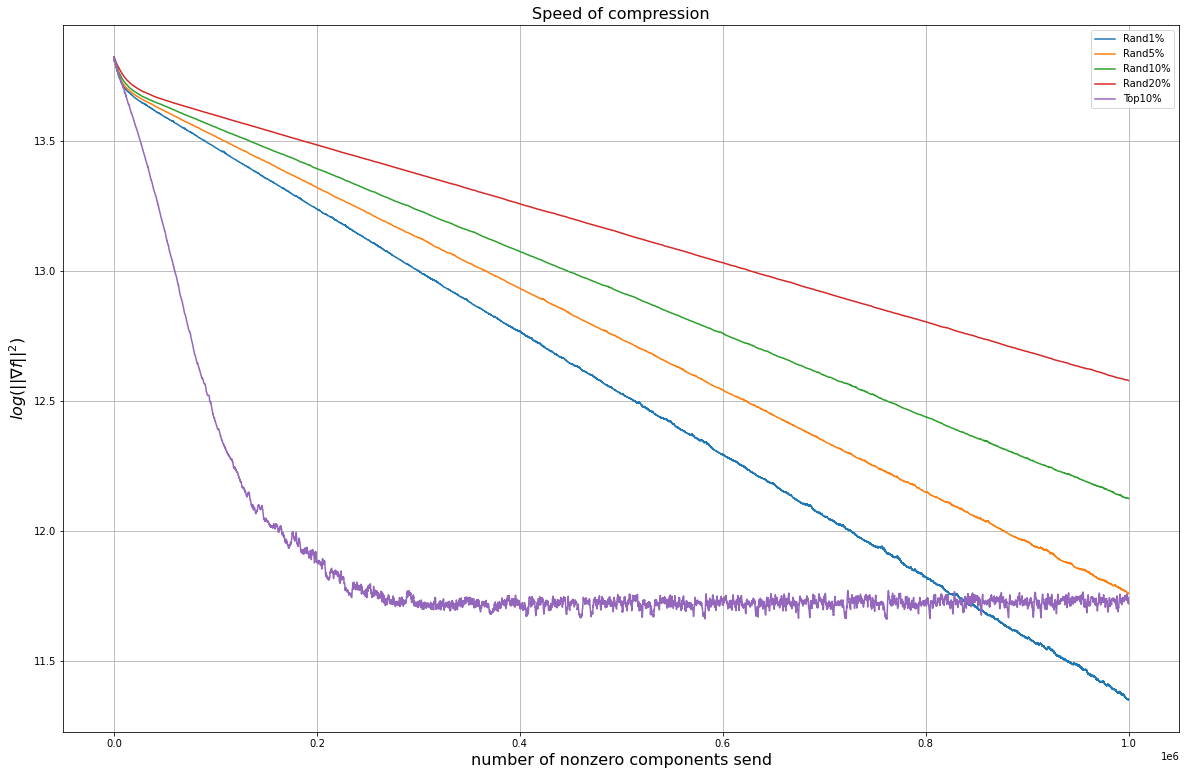

In [321]:
plt.figure(figsize=(20, 13))  
plt.title('Speed of compression', fontsize=16)  
plt.plot(gd_rand_1.information_send, np.log(gd_rand_1.grad_history), label='Rand1%') 
plt.plot(gd_rand_5.information_send, np.log(gd_rand_5.grad_history), label='Rand5%') 
plt.plot(gd_rand_10.information_send, np.log(gd_rand_10.grad_history), label='Rand10%') 
plt.plot(gd_rand_20.information_send, np.log(gd_rand_20.grad_history), label='Rand20%')  
plt.plot(gd_top_10.information_send, np.log(gd_top_10.grad_history), label='Top10%')
plt.xlabel('number of nonzero components send', fontsize=16) 
plt.ylabel(r"$log(||\nabla f||^{2})$", fontsize=16)
plt.grid() 
plt.legend() 
plt.show()

## Тяжело делать какие-то выводы, да мы видим, что сходисть линейная у каждого метода, но TopK имеет преимущество по скорости. Также стоит отметить, что из-за того что мы берем k самых больших координат, мы тем самым не можем уловить сходимость по другим координатам, поэтому остаемся на одиннаковом уровне. Можно заметить что Rand1% cходится лучше всех, так как получается у него больше итераций и как бы можно сказать, что на каждую пересылку он более информативней чем его коллеги.

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [164]:
class UpdateGradientDescent: 
    def __init__(self, A, b, max_iter, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_iter = max_iter  
        self.lr = lr 
        self.x = None 
        self.iteration = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d)
        for i in range(self.max_iter):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)
            for j in range(self.workers): 
                h = grad(A[j], b[j], self.x, self.d) 
                full_g = full_g + h 
                g = g + Compression(self.name, self.percents, h, self.d)  
            g *= 1/self.workers 
            full_g *= 1/self.workers 
            self.x = self.x - self.lr * g
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.iteration.append(i + 1) 

In [165]:
class EFGradientDescent: 
    def __init__(self, A, b, max_iter, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_iter = max_iter  
        self.lr = lr 
        self.x = None 
        self.iteration = []  
        self.information_send = []
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d) 
        e_help = np.zeros((self.d, self.d))
        information = 0 
        
        for i in range(self.max_iter): 
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d) 
            
            for j in range(self.workers): 
                h = grad(self.A[j], self.b[j], self.x, self.d) 
                full_g += h 
                grad_update = e_help[j] + self.lr * h  
                grad_update_compression = Compression(self.name, self.percents, grad_update, self.d)
                g += grad_update_compression
                e_help[j] = grad_update - grad_update_compression  
                
            g *= 1/self.workers 
            full_g *= 1/self.workers
            self.x = self.x - g  
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += self.k * self.workers
            self.iteration.append(i+1)  

In [166]:
gd_top_10 = UpdateGradientDescent(A, b, 10**6, 1/(4 * L * (1 + 2 * 10 * 1/n)), n, 'TopK', 0.1, d) 
efgd_top_10 = EFGradientDescent(A, b, 10**6, 1/(14 * L * 2 * 10), n, 'TopK', 0.1, d) 

In [167]:
gd_top_10.fit() 
efgd_top_10.fit()

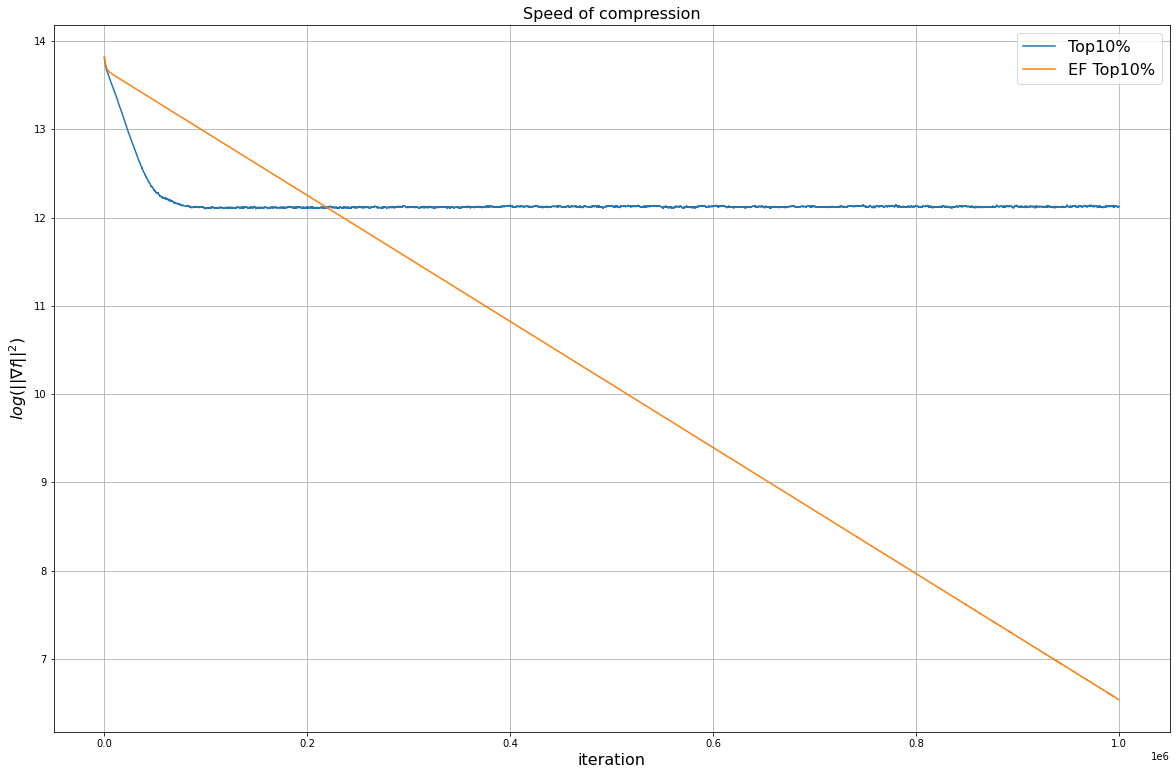

In [168]:
plt.figure(figsize=(20, 13))  
plt.title('Speed of compression', fontsize=16)  
plt.plot(gd_top_10.iteration, np.log(gd_top_10.grad_history), label='Top10%') 
plt.plot(efgd_top_10.iteration, np.log(efgd_top_10.grad_history), label='EF Top10%') 
plt.xlabel('iteration', fontsize=16) 
plt.ylabel(r"$log(||\nabla f||^{2})$", fontsize=16)
plt.grid() 
plt.legend(fontsize=16) 
plt.show()

## Видим колоссальное преимущество EF подхода над другими,  он сходится достаточно быстро,  правда требует немного больше памяти, но оно того стоило!Еще мне кажется этот метод неустойчивым, так как слишком сильно зависит от типа сжатия

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [6]:
dataset = "mushrooms.txt" 

In [7]:
from sklearn.datasets import load_svmlight_file 
from sklearn.model_selection import train_test_split 

data = load_svmlight_file(dataset)  
X, y = data[0].toarray(), data[1]  

n, d = X.shape

p = np.random.permutation(n) 

X = X[p] 
y = y[p] 

y = 2 * y - 3  

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(X_train.shape)

(6499, 112)


In [9]:
indices = np.random.permutation(X_train.shape[0])   
X_tmp = X_train[indices]  
y_tmp = y_train[indices] 

workers_x = [] 
workers_y = [] 

batch_size = 650 
for i in range(10): 
    workers_x.append(X_tmp[i * batch_size : min((i + 1) * batch_size, X_train.shape[0])])  
    workers_y.append(y_tmp[i * batch_size : min((i + 1) * batch_size, y_train.shape[0])])

In [10]:
#теперь для каждой f_i найдем константу липишица по уже старому проверенному дедовскому методу 
#будем искать ее как максимум среди всех максимальных значений гессиана из предыдущих домашних работ 

In [13]:
maxi = -1
for i in range(10): 
    hessian = np.zeros((d, d)) 
    for j in range(workers_x[i].shape[0]): 
        hessian += np.dot(workers_x[i][j], workers_x[i][j].T) 
    hessian /= 4 * workers_x[i].shape[0]
    L = np.amax(np.linalg.eigvals(hessian))  
    if(L > maxi): 
        maxi = L 
print('L = %0.2f' % L.real)

L = 588.00


In [14]:
reg = L/1000

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [83]:
def grad(batch_x, batch_y, batch_size, w, reg): 
    g = np.zeros(d) 
    for j in range(batch_size):  
        g = g + (-batch_y[j] * batch_x[j]) / (1 + np.exp(batch_y[j] * np.dot(w.T, batch_x[j]))) 
    return g / batch_size + 2 * reg * w 

In [123]:
class DIANA: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg, alpha): 
        self.data_worker_x = data_worker_x 
        self.data_worker_y = data_worker_y
        self.workers = workers 
        self.lr = lr 
        self.max_iter = max_iter  
        self.name = name 
        self.percents = percents 
        self.d = d 
        self.information_send = [] 
        self.grad_history = [] 
        self.w = None 
        self.reg = reg   
        self.alpha = alpha 
        #на самом деле тут должно быть в (workers + 1) раза памяти больше ибо храним h и на сервере 
        #и на компьютерах 
        
    def fit(self): 
        self.w = np.zeros(self.d)   
        h = np.zeros((self.workers, self.d)) 
        k = int(self.percents * d) 
        information = 0 
        for i in range(self.workers): 
            h[i] = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg) 
        
        for i in range(self.max_iter):  
            g = np.zeros(self.d)  
            full_g = np.zeros(self.d) 
            for j in range(self.workers): 
                delta = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, reg) 
                full_g = full_g + delta
                delta = delta - h[j]
                delta_compressed = Compression(self.name, self.percents, self.w, self.d)  
                g += h[j] + delta_compressed
                h[j] += self.alpha * delta_compressed 
        
            self.w = self.w - self.lr * 1/self.workers * g 
            self.grad_history.append(np.linalg.norm(1/self.workers * full_g)**2) 
            information += k * self.workers 
            self.information_send.append(information)

In [124]:
class EFGradientDescent: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = []
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg
    
    def fit(self): 
        self.w = np.zeros(self.d)
        e_help = np.zeros((self.d, self.d))
        information = 0 
        
        for i in range(self.max_iter): 
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d) 
            
            for j in range(self.workers): 
                h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                full_g = full_g + h 
                grad_update = e_help[j] + self.lr * h  
                grad_update_compression = Compression(self.name, self.percents, grad_update, self.d)
                g = g + grad_update_compression
                e_help[j] = grad_update - grad_update_compression  
                
            g *= 1/self.workers 
            full_g *= 1/self.workers
            self.w = self.w - g  
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += self.k * self.workers
            self.information_send.append(information)  

In [125]:
class UpdateGradientDescent: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg 
    
    def fit(self): 
        self.w = np.zeros(self.d) 
        information = 0
        for i in range(self.max_iter):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)
            for j in range(self.workers): 
                h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                full_g = full_g + h 
                g = g + Compression(self.name, self.percents, h, self.d)  
            g *= 1/self.workers 
            full_g *= 1/self.workers 
            self.w = self.w - self.lr * g
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += self.k * self.workers
            self.information_send.append(information)

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [134]:
diana_top_k = DIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'TopK', 0.1, d, L/1000, 1/11) 
diana_rand_k = DIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'RandK', 0.1, d, L/1000, 1/11)

In [135]:
ef_top_k = EFGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'TopK', 0.1, d, L/1000) 
ef_rand_k = EFGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'RandK', 0.1, d, L/1000)

In [136]:
gd_top_k = UpdateGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'TopK', 0.1, d, L/1000) 
gd_rand_k = UpdateGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'RandK', 0.1, d, L/1000) 

In [137]:
diana_top_k.fit() 
diana_rand_k.fit() 

/tmp/ipykernel_37268/1421662064.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  h[i] = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg)
/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]


In [138]:
ef_top_k.fit() 
ef_rand_k.fit() 

/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]
/tmp/ipykernel_37268/2613360206.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  e_help[j] = grad_update - grad_update_compression
/tmp/ipykernel_37268/1189897838.py:4: RuntimeWarning: overflow encountered in exp
  g = g + (-batch_y[j] * batch_x[j]) / (1 + np.exp(batch_y[j] * np.dot(w.T, batch_x[j])))


In [139]:
gd_top_k.fit()
gd_rand_k.fit() 

/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]


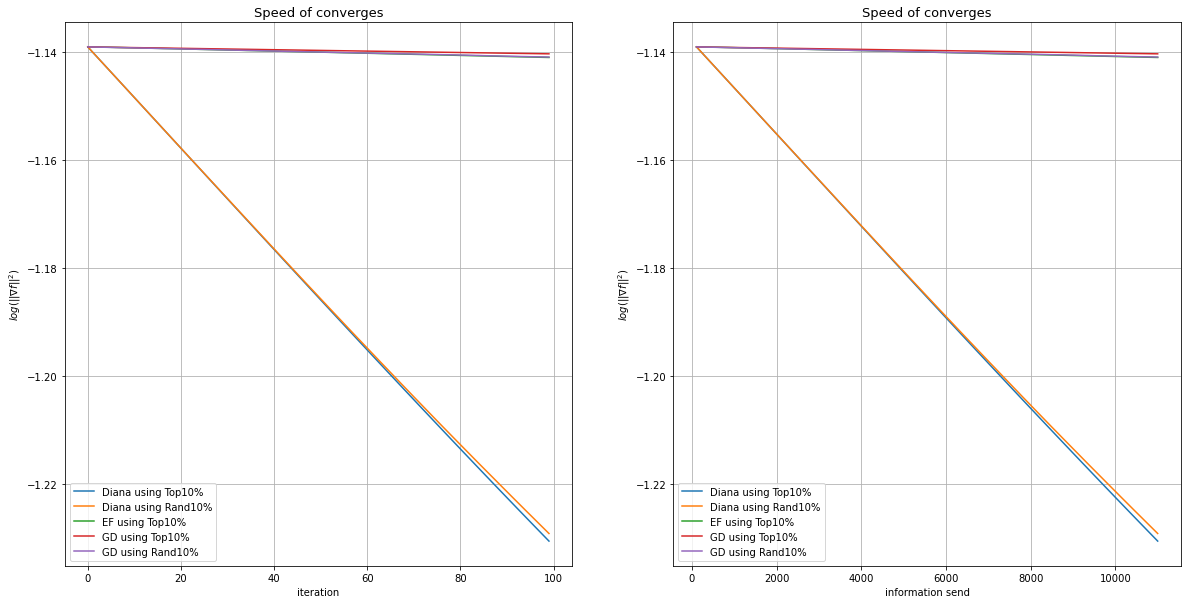

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  

ax[0].set_title('Speed of converges', fontsize=13) 
ax[1].set_title('Speed of converges', fontsize=13) 
ax[0].grid() 
ax[1].grid()  
ax[0].set_xlabel('iteration', fontsize=10) 
ax[0].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=10) 
ax[1].set_xlabel('information send', fontsize=10) 
ax[1].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=10)  

ax[0].plot(range(0, diana_top_k.max_iter, 1), np.log(diana_top_k.grad_history), label = 'Diana using Top10%')
ax[0].plot(range(0, diana_rand_k.max_iter, 1), np.log(diana_rand_k.grad_history), label = 'Diana using Rand10%') 
ax[0].plot(range(0, ef_top_k.max_iter, 1), np.log(ef_top_k.grad_history), label = 'EF using Top10%')  
#ax[0].plot(range(0, ef_rand_k.max_iter, 1), np.log(ef_rand_k.grad_history), label = 'EF using Rand10%')  
ax[0].plot(range(0, gd_top_k.max_iter, 1), np.log(gd_top_k.grad_history), label = 'GD using Top10%') 
ax[0].plot(range(0, gd_rand_k.max_iter, 1), np.log(gd_rand_k.grad_history), label = 'GD using Rand10%')   
ax[0].legend()

ax[1].plot(diana_top_k.information_send, np.log(diana_top_k.grad_history), label = 'Diana using Top10%')
ax[1].plot(diana_rand_k.information_send, np.log(diana_rand_k.grad_history), label = 'Diana using Rand10%') 
ax[1].plot(ef_top_k.information_send, np.log(ef_top_k.grad_history), label = 'EF using Top10%')  
#ax[1].plot(ef_rand_k.information_send, np.log(ef_rand_k.grad_history), label = 'EF using Rand10%')  
ax[1].plot(gd_top_k.information_send, np.log(gd_top_k.grad_history), label = 'GD using Top10%') 
ax[1].plot(gd_rand_k.information_send, np.log(gd_rand_k.grad_history), label = 'GD using Rand10%') 
ax[1].legend() 

## Как видим DIANA полностью решает вопрос с сигмой со звездочкой(с семинара) и позволяет нам быстрее сходится чем остальные методы(с линейной скоростью). На данной задаче можно увидеть, что как раз не равная нулю сигма со звездочкой приводит к тому что EF и GD не сильно отличаются

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [141]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#ответ